# Parte 3

## Regresión Logística:

La regresión logística es un modelo de clasificación binaria basado en la función logistica para predecir la probabilidad de un evento para de partenecer a alguna clase. La función logística está dada por:

%%latex

\begin{equation*}
\begin{aligned}
& & g(z) = \frac{1}{1+e^{-z}} \\
\end{aligned}
\end{equation*}

La probabilidad de pertenecer a la clase positiva queda dada entonces por:


%%latex
\begin{equation*}
\begin{aligned}
\mathbb{P}(\text{event x is positive}) = g(\beta^{\intercal}x) = \frac{1}{1+e^{-\beta^{\intercal}x}}
\end{aligned}
\end{equation*}

Donde el la variable beta representa el vector de parámetros que multiplican a cada variable, los cuales son ajustados para minimizar una función de pérdida. En este caso se usará la función de Cross-Entropy, definida como:


%%latex

\begin{equation*}
\begin{aligned}
\frac{1}{N} \sum_{i=1}^{N} \big(y_{i}log(\hat{y})+(1-y_{i})log(1-\hat{y}) \big)
\end{aligned}
\end{equation*}


La optimización de los parámetros para minimizar la función de pérdida será luego realizada mediante el método de Gradient Descent

In [125]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import sklearn
%matplotlib inline 

In [90]:
#Importar la base de datos
local_path = r'/Users/pablouribepizarro/Desktop/Analisis de Datos/Tarea_1/'
datos = pd.read_csv(local_path + 'data_new_features_clean.csv',index_col =0)

In [91]:
#Cambiar el formato de las fechas a datetime

datos['FechaNac'] = pd.to_datetime(datos['FechaNac'])
datos['FechaReserva'] = pd.to_datetime(datos['FechaReserva'])
datos['FechaCita'] = pd.to_datetime(datos['FechaCita'])
datos = datos.sort_values('FechaCita')

In [96]:
#Transformar el problema en uno de clasificación binaria:
def binario(estadocita):
    if (estadocita =='Cancelado') or (estadocita =='No Atendido'):
        return('Cita No Realizada')
    elif (estadocita =='Atendido'):
        return('Cita Realizada')
    else:
        return(estadocita)
#Modificación de la columna:
datos['EstadoCita'] = datos.apply(lambda row: binario(row['EstadoCita']),axis=1)

In [99]:
#Creación de una muestra balanceada:
datos_neg = datos.loc[datos['EstadoCita'] == 'Cita No Realizada'].copy()
datos_pos = datos.loc[datos['EstadoCita'] == 'Cita Realizada'].copy()

num = min(datos_neg.shape[0],datos_pos.shape[0])
pos_sample = datos_neg.sample(num)
neg_sample = datos_pos.sample(num)


balanced_sample = pd.concat([pos_sample,neg_sample]).sample(frac=1)

In [102]:
#Encoder String a Numérico
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


column_list = [] #str columns
for column in datos.columns:
    if balanced_sample[column].dtype == 'O':
        column_list.append(column)

datos_num = balanced_sample[column_list].astype(str).apply(le.fit_transform)
for column in balanced_sample.columns:
    if balanced_sample[column].dtype != 'O':
        datos_num[column] = balanced_sample[column]

In [103]:
#Estandarización de los Datos
from sklearn import preprocessing
stand_data = preprocessing.StandardScaler().fit_transform(datos_num.drop(
                                                ['FechaNac','FechaCita','FechaReserva','EstadoCita'],axis=1))
stand_data = pd.DataFrame(stand_data)
stand_data.columns = datos_num.drop(
                                        ['FechaNac','FechaCita','FechaReserva','EstadoCita'],axis=1).columns.values
stand_data= stand_data.set_index(datos_num.index.values)
stand_data['EstadoCita'] = datos_num['EstadoCita']

## Implementación de la Regresión Logística

En esta seccióin se mostrará la implementación de la regresión logística en forma de clase.

In [111]:
class RegresionLogistica:
    #Inicialización de la clase
    def __init__(self, step_size=0.01, n_iteraciones=10000, fit_intercept = True):
        self.step_size = step_size
        self.n_iter = n_iteraciones
        self.n_interaciones = 10000
        self.fit_intercept = fit_intercept
        
    def __add_intercept(self,X):
        intercept = np.ones((X.shape[0],1))
        return(np.concatenate(intercept,X,axis =1))
    
    #Definición de la Función Sigmoid:
    def __sigmoid(self,z):
        return(1/(1+np.exp(-z)))
    
    #Definición de la función de pérdida: Cross-Entropy
    def __crossentropyloss(h,y):
        return(-y*np.log(h)-(1-y)*np.log(1-h)).mean()
    #función fit: optimización de los parámetros theta usando GD
    def fit(self, X, y):
        #Inicialización de los parámetros (0 para cada componente):
        self.theta = np.zeros(X.shape[1])
        #Gradient Descent
        for i in range(self.n_iter):
            z = np.dot(X, self.theta) #Producto punto entre variables y parámetros
            h = self.__sigmoid(z) #Evaluación de la predicción con los parámetros
            gradient = np.dot(X.T,(h-y))/y.size #cálculo del gradiente
            self.theta -=self.step_size*gradient #Actualización de los parámetros con GD y el step size  
    
    #Funcion de predicción en probabilidad:
    def pred_probabilidad(self,X):
        return(self.__sigmoid(np.dot(X,self.theta)))
    
    #Función de predicción por sobre 0.5
    def pred(self, X):
        return ([self.pred_probabilidad(X) >=0.5][0])

            
            
    

In [113]:
#Creación de una muestra de entrenamiento y validación:
msk = np.random.rand(len(stand_data)) < 0.5
train = stand_data[msk]
test = stand_data[~msk]

In [119]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [121]:
#Entrenamiento del modelo: Variables Originales
X_train = train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']]
y_train = train['EstadoCita']

X_test = test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']]
y_test = test['EstadoCita']

model = RegresionLogistica()
%time model.fit(X_train, y_train)

preds = model.pred(X_test)
# accuracy
(preds == y_test).mean()

CPU times: user 37.6 s, sys: 973 ms, total: 38.5 s
Wall time: 21.8 s


0.5411924060035392

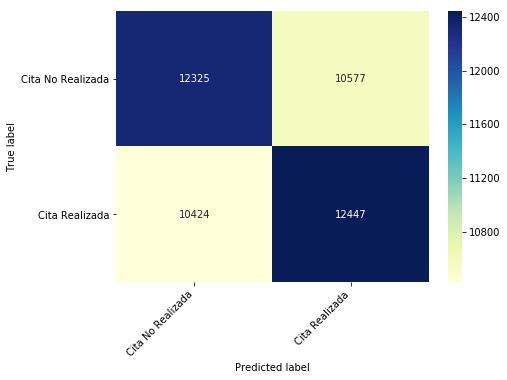

In [122]:
from sklearn.metrics import confusion_matrix
class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'], preds)
cm_fig = print_confusion_matrix(cm,class_names)

In [123]:
#Entrenamiento del modelo: Variables Nuevas
X_train = train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita','Mes Cita']]
y_train = train['EstadoCita']
X_test = test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita','Mes Cita']]
y_test = test['EstadoCita']

model = RegresionLogistica()
%time model.fit(X_train, y_train)

preds = model.pred(X_test)
# accuracy
(preds == y_test).mean()

CPU times: user 50.5 s, sys: 915 ms, total: 51.4 s
Wall time: 26.7 s


0.5912437463133288

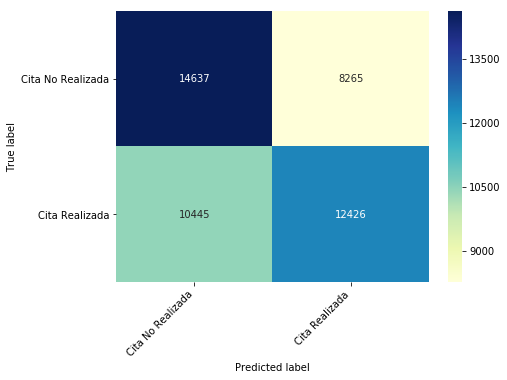

In [124]:
from sklearn.metrics import confusion_matrix
class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_t ransform(class_numbers)
cm = confusion_matrix(test['EstadoCita'], preds)
cm_fig = print_confusion_matrix(cm,class_names)